Made to try to figure out how to line up dates even though they have different calendar types

Kind of a hacky approach for now, but I think it is OK?

**Known issues**:
- Duplicate Dates
   * CESM2 has duplicate dates (for now, just skipping this model)
   * SSP245 and SSP585 have tons of duplicate dates
- Can't decode times for CanESM5
- Takes a really long time to run - not sure why
- Not actually the global mean, because not area weighting grid cells... this is OK b/c eventually will look at individual lat/lon - just proof of concept for now
- Kernel often dies (memory issue? for now, just trying to plot a few models instead of all of them)
- Not everything is showing up when I plot it - maybe didn't merge into xarray dataset super well??

**Questions:**
- How is dask embedded in here somehow??

### Set up Workspace

In [4]:
%matplotlib inline

import xarray as xr
import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import xesmf as xe

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 
output_path='/home/jovyan/cmip6-outreach-tool/output/'

In [5]:
######### Define Settings for Data Dictionary
this_experiment_id = ['historical','ssp126', 'ssp370']  #ssp245,ssp585 have way too many duplicates in time dimension
this_variable_id = 'tas'
this_table_id = 'Amon'
this_grid_label='gn'


######### Create Data Dictionary
import CreateDataDict
[dataset_info, dset_dict, modelnames]=CreateDataDict.createDataDict(this_experiment_id, this_variable_id, this_table_id, this_grid_label)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 39 group(s)


### Regrid

In [13]:
### Create ds_out reference file
def CreateReferenceGrid(modelname, experiment_id,activity_id):
    dataset_info_subset = dataset_info[dataset_info['source_id']==modelname]
    institution_id = list(set(dataset_info_subset['institution_id']))[0]
    nametag=activity_id+'.'+institution_id+'.'+modelname+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
    thisdata=dset_dict[nametag]
    ds_out = xr.Dataset({'lat': thisdata['lat'],
                         'lon': thisdata['lon']})
    return ds_out

ds_out = CreateReferenceGrid(modelname='CAMS-CSM1-0', activity_id = 'CMIP', experiment_id='historical')

In [28]:
def RegridModel(thisdata,latvariable='lat',lonvariable='lon'):
    ds_in = xr.Dataset({'lat': thisdata[latvariable],
                    'lon': thisdata[lonvariable],
                    'time': thisdata['time'],
                    'tas': thisdata['tas']})
    regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
    thisdata_regridded = regridder(ds_in)
    thisdata_regridded.attrs.update(thisdata.attrs)
    return thisdata_regridded

In [ ]:
mapdata_regridded=ds1_regridded[varname].mean(dim='time').values
lats=ds1_regridded['lat'].values
lons=ds1_regridded['lon'].values
print(np.shape(lats))
print(np.shape(lons))
print(np.shape(mapdata_regridded))
quick_map(mapdata_regridded,lats,lons,clim=[200,300])

mapdata_original=ds1[varname].mean(dim='time').values
lats=ds1['lat'].values
lons=ds1['lon'].values
print(np.shape(lats))
print(np.shape(lons))
print(np.shape(mapdata_original))
quick_map(mapdata_original,lats,lons,clim=[200,300])

### Create Xarray dataset of time series for all models

In [37]:
def reindex_time(startingtimes):
    newtimes = startingtimes.values
    for i in range(0,len(startingtimes)):
        yr = int(str(startingtimes.values[i])[0:4])
        mon = int(str(startingtimes.values[i])[5:7])
        day = int(str(startingtimes.values[i])[8:10])
        hr = int(str(startingtimes.values[i])[11:13])
        newdate = cftime.DatetimeProlepticGregorian(yr,mon,15)
        newtimes[i]=newdate
    return newtimes

def initializeDataSet(activity_id,experiment_id,modelname):
    dataset_info_subset = dataset_info[dataset_info['source_id']==modelname]
    institution_id = list(set(dataset_info_subset['institution_id']))[0]
    nametag=activity_id+'.'+institution_id+'.'+modelname+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
    thisdata=dset_dict[nametag]
    thisdata=xr.decode_cf(thisdata)
    thisdata = thisdata.mean(dim=['member_id'])
    ###### Reformat dates to be Proleptic Gregorian date type
    newtimes = reindex_time(startingtimes = thisdata['time'])
    thistime = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
    thisdata['time'] = thistime
    ###### Regrid 
    
    #########################################
    thisval=thisdata['tas'] #.mean(dim=['lat','lon'])
    ds = xr.Dataset({modelname: thisval},\
                    coords={'time': thistime})
                            #'modelnames': modelnameInd, \
                            #'lat': thislat, \
                            #'lon': thislon, \
                
    return ds

def fillDataSet():
    modelnames_toplot = []
    for modelname in modelnames:
        source_id = modelname
        dataset_info_subset = dataset_info[dataset_info['source_id']==source_id]
        institution_id = list(set(dataset_info_subset['institution_id']))[0]
        nametag = activity_id+'.'+institution_id+'.'+source_id+'.'+experiment_id+'.'+this_table_id+'.'+this_grid_label
        if nametag in dset_dict:
            ###### Reformat dates to be Proleptic Gregorian date type
            if (modelname=='MCM-UA-1-0') or (modelname=='CESM2')and(experiment_id=='historical') or ((modelname=='CanESM5')and(experiment_id=='ssp126'))or ((modelname=='CESM2-WACCM')and(experiment_id=='ssp370')):
                print('** Skipping '+modelname)
            else:
                print(modelname)
                modelnames_toplot.append(modelname)
                thisdata=dset_dict[nametag]
                thisdata=xr.decode_cf(thisdata)
                thisdata = thisdata.mean(dim=['member_id'])
                newtimes = reindex_time(startingtimes = thisdata['time'])
                thisdata['time'] = xr.DataArray(newtimes, coords=[newtimes], dims=['time'])
                ###### Regrid this
                thisdata=RegridModel(thisdata)
                thisval=thisdata['tas'] #.mean(dim=['lat','lon'])
                ds[modelname]=thisval
    return ds,modelnames_toplot

In [38]:
dict_timeSeries = dict()

for experiment_id in this_experiment_id:
    print('---------------'+experiment_id+'---------------')
    if experiment_id=='historical':
        activity_id='CMIP'
    else:
        activity_id='ScenarioMIP'

    # Create xarray dataset using one model         
    ds= initializeDataSet(activity_id,experiment_id,modelname='CAMS-CSM1-0')

    # read data from all other models into xarray dataset
    [ds,modelnames_toplot] = fillDataSet()
    
    # Convert from K to C
    for modelname in modelnames_toplot:
        ds[modelname]=ds[modelname]-273.15

    #Add dataset to dictionary
    dict_timeSeries[experiment_id] = ds
    dict_timeSeries[experiment_id+'_modelnameToPlot'] = modelnames_toplot

---------------historical---------------
GISS-E2-1-G-CC
Overwrite existing file: nearest_s2d_90x144_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
BCC-ESM1
Overwrite existing file: nearest_s2d_64x128_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
MRI-ESM2-0
Overwrite existing file: nearest_s2d_160x320_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
UKESM1-0-LL
Overwrite existing file: nearest_s2d_144x192_160x320.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
NorCPM1
Overwrite existing file: nearest_s2d_96x144_16

In [48]:
lats = dict_timeSeries['historical']['lat'].values
lons = dict_timeSeries['historical']['lon'].values
thislat = 47.6062 #(47.6062 N)
thislon = 237.67 #(122.3321 W)
result = np.where(abs(lats-thislat) == np.amin(abs(lats-thislat)))
result = np.where(abs(lats-thislat) == np.amin(abs(lats-thislat)))
print(result)

(array([122]),)


### Plot Time Series

---------------historical---------------
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MIROC6


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MCM-UA-1-0
HadGEM3-GC31-LL
CanESM5
CESM2-WACCM
NorCPM1
UKESM1-0-LL
GISS-E2-1-G
NESM3


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


BCC-ESM1
GISS-E2-1-H
MRI-ESM2-0


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CAMS-CSM1-0
BCC-CSM2-MR
SAM0-UNICON
GISS-E2-1-G-CC
---------------ssp126---------------
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MIROC6


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CESM2
CESM2-WACCM
UKESM1-0-LL
MRI-ESM2-0


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CAMS-CSM1-0
BCC-CSM2-MR
MPI-ESM1-2-HR


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


---------------ssp370---------------
MIROC-ES2L


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


MIROC6


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CESM2
CanESM5
UKESM1-0-LL
MRI-ESM2-0


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CAMS-CSM1-0
BCC-CSM2-MR
MPI-ESM1-2-HR


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


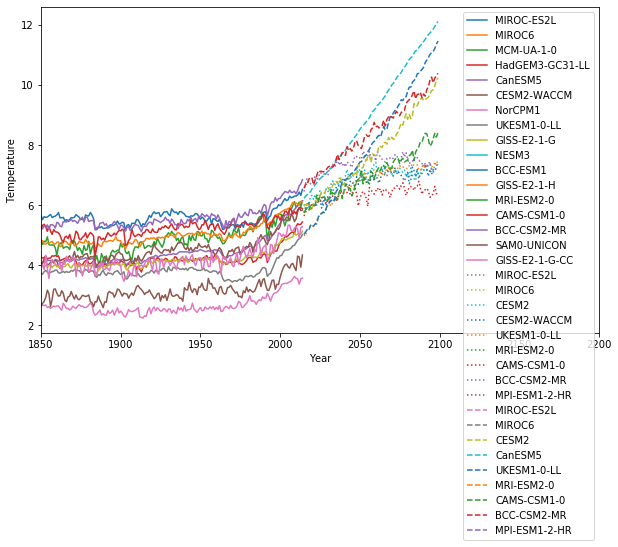

In [7]:
fig = plt.figure(figsize=(10,6))
lstyle = ['-',':','--','-.','-']
fname='Historical-and-ScenarioTimeSeries'
for i in range(0,len(this_experiment_id)):
    experiment_id = this_experiment_id[i]
    # Read in data for experiment id
    print('---------------'+experiment_id+'---------------')
    modelnames_toplot = dict_timeSeries[experiment_id+'_modelnameToPlot']
    ds = dict_timeSeries[experiment_id]
    
    # Calculate annual mean
    ds_annual=ds.groupby('time.year').mean('time')
    
    for modelname in modelnames_toplot:
        print(modelname)
        plt.plot(ds_annual['year'],ds_annual[modelname],label=modelname,linestyle=lstyle[i])
plt.legend()
plt.xlabel('Year')
plt.xlim([1850,2200])
plt.ylabel('Temperature')
fig.savefig(output_path +fname+'.png', bbox_inches='tight') 